daten von disk laden

In [1]:
import os
import keras_core as keras

dataset = keras.utils.image_dataset_from_directory(
        os.path.join("data", "images"),
        labels="inferred",
        label_mode="int",
        color_mode="rgb",
        batch_size=64,
        image_size=(128, 128),
        shuffle=True,
        interpolation="bilinear",
        crop_to_aspect_ratio=True,
        validation_split=0.2,
        subset="both",
        seed=42,
    )
data_train = dataset[0]
data_val = dataset[1]

data_val, data_train

Using TensorFlow backend
Found 9100 files belonging to 7 classes.
Using 7280 files for training.
Using 1820 files for validation.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

data augmentation

In [2]:
from keras_core import layers

preprocessing_layer = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
])
data_train = data_train.map(lambda x, y: (preprocessing_layer(x), keras.utils.to_categorical(y, num_classes=7)))
data_val = data_val.map(lambda x, y: (preprocessing_layer(x), keras.utils.to_categorical(y, num_classes=7)))

data_train, data_val

(<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>)

plot data

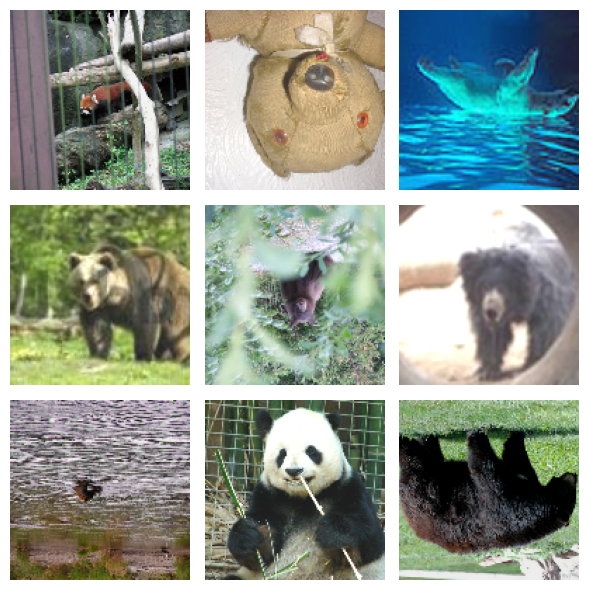

In [3]:
from keras_cv.src.visualization import plot_image_gallery

batch = next(iter(data_train.take(1)))
images, labels = batch
plot_image_gallery(
    batch[0],
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

train cnn

In [4]:
model = keras.Sequential([
    layers.Conv2D(32, (4, 4), activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, (4, 4), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, (4, 4), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(256, (4, 4), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(7, activation='softmax'),
])
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
model.summary()

M:\apps\anaconda\envs\deepl\Lib\site-packages\keras_core\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 125, 125, 32)      │      1,568 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 59, 59, 64)        │     32,832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)       │    131,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 256)       │    524,544 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 6400)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 7)                 │     44,807 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 734,951 (2.80 MB)

 Trainable params: 734,951 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from livelossplot import PlotLossesKeras

history = model.fit(
    x=data_train,
    validation_data=data_val,
    epochs=5,
    callbacks=[PlotLossesKeras()],
)

Epoch 1/5
 11/114 ━━━━━━━━━━━━━━━━━━━━ 1:16 740ms/step - accuracy: 0.1812 - loss: 32.8306

KeyboardInterrupt: 